# NOT YET ADAPTED FOR GENERAL USE

# Image Segmentation Models: Baseline Training and Predictions

Notebook adapted from [Dr. Sreenivas Bhattiprolu](https://github.com/bnsreenu/python_for_microscopists/tree/master/228_semantic_segmentation_of_aerial_imagery_using_unet)

In [ ]:
# Google Colab specific
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
    print('Not connected to a GPU')
else:
    print(gpu_info)

Mon Jun 13 09:23:52 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    29W /  70W |  14872MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install keras==2.3.1
!pip install tensorflow==2.1.0
!pip install keras_applications==1.0.8
!pip install image-classifiers==1.0.0
!pip install efficientnet==1.0.0

In [ ]:
!pip install -U segmentation-models

In [3]:
# Replace saving.py file with fix. NEED TO RESTART RUNTIME AFTERWARDS
!cp /content/drive/MyDrive/Trustbit/saving.py /usr/local/lib/python3.7/dist-packages/keras/engine/

In [4]:
import os
import cv2
import numpy as np
import random

from matplotlib import pyplot as plt
from matplotlib.colors import ListedColormap
from PIL import Image
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

from sklearn.preprocessing import MinMaxScaler, StandardScaler
scaler = MinMaxScaler()

# Set working directory
%cd /content/drive/MyDrive/Trustbit/U-Net-YT

root_directory = '/content/drive/MyDrive/Trustbit/U-Net-YT'

#patch_size = 256*2  # 512x512 images!
patch_size = 480                                                              ##### PSPNet

Using TensorFlow backend.


Segmentation Models: using `keras` framework.
/content/drive/MyDrive/Trustbit/U-Net-YT


## Pre-Processing

In [5]:
#Read images from respective 'images' subdirectory
#As all images are of ddifferent size we have 2 options, either resize or crop
#But, some images are too large and some small. Resizing will change the size of real objects.
#Therefore, we will crop them to a nearest size divisible by 256 and then 
#divide all images into patches of 256x256x3. 
image_dataset = []  
mask_dataset = []
image_name_ls = []
mask_name_ls = []
counter = 0

path = os.path.join(root_directory, "data-480-n")

images = os.listdir(path)  #List of all image names in this subdirectory
images.sort()

for i, image_name in enumerate(images):
    if counter > 399:
        if len(image_dataset) == len(mask_dataset):
            break

    if image_name.endswith(".jpeg") and image_name.startswith("T"):   #Only read truck and jpg images...
        #print(path+"/"+image_name)
        image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR

        #image = Image.fromarray(image)                                      ##### PSPNet
        #image = image.crop((0 ,0, 384, 384))  #Crop from top left corner    ##### PSPNet
        #image = image.resize((384, 384))     #Try not to use
        image = np.array(image)
        
        img = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
                
        image_dataset.append(img)
        image_name_ls.append(image_name)

    elif image_name.endswith("MASK.png") and image_name.startswith("T"):
        mask = cv2.imread(path+"/"+image_name, 1)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        #mask = Image.fromarray(mask)                                        ##### PSPNet
        #mask = mask.crop((0 ,0, 384, 384))                                  ##### PSPNet
        mask = np.array(mask)   

        mask_dataset.append(mask)
        mask_name_ls.append(image_name)

        counter += 1
"""
counter = 0

for i, image_name in enumerate(images):
    if counter > 399:
        if len(image_dataset) == len(mask_dataset):
            break

    if image_name.endswith(".jpeg") and image_name.startswith("C"):   #Only read truck and jpg images...
        #print(path+"/"+image_name)
        image = cv2.imread(path+"/"+image_name, 1)  #Read each image as BGR

        #image = Image.fromarray(image)                                      ##### PSPNet
        #image = image.crop((0 ,0, 384, 384))  #Crop from top left corner    ##### PSPNet
        #image = image.resize((384, 384))     #Try not to use
        image = np.array(image)
        
        img = scaler.fit_transform(image.reshape(-1, image.shape[-1])).reshape(image.shape)
                
        image_dataset.append(img)
        image_name_ls.append(image_name)

    elif image_name.endswith("MASK.png") and image_name.startswith("C"):
        mask = cv2.imread(path+"/"+image_name, 1)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        #mask = Image.fromarray(mask)                                        ##### PSPNet
        #mask = mask.crop((0 ,0, 384, 384))                                  ##### PSPNet
        mask = np.array(mask)   

        mask_dataset.append(mask)
        mask_name_ls.append(image_name)

        counter += 1
"""
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)


if len(image_dataset) != len(mask_dataset):
    print("ERROR: Lengths differ!")
else:
    print("Images:", len(image_dataset))

Images: 400


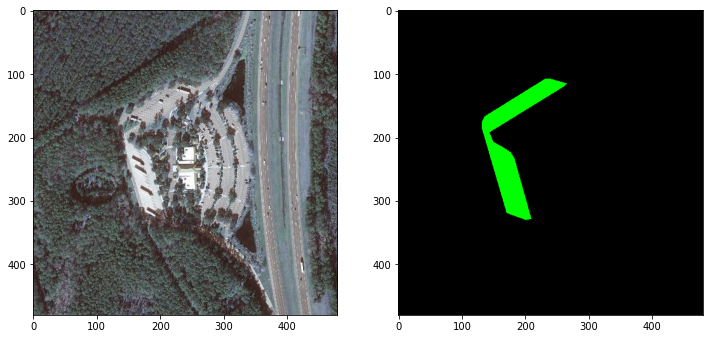

In [ ]:
#Sanity check, view few images
image_number = random.randint(0, len(image_dataset))
#image_number = 3

plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(np.reshape(mask_dataset[image_number], (patch_size, patch_size, 3)))
plt.show()

In [6]:
# Now replace RGB to integer values to be used as labels.
#Find pixels with combination of RGB for the above defined arrays...
#if matches then replace all values in that pixel with a specific integer
background =    np.array([0, 0, 0])
truck_parking = np.array((0, 255, 0))
car_parking =   np.array((0, 0, 255))

def rgb_to_2D_label(label):
    
    #Supply our labale masks as input in RGB format. 
    #Replace pixels with specific RGB values ...

    label_seg = np.zeros(label.shape, dtype=np.uint8)
    label_seg[np.all(label==background, axis=-1)] = 0
    label_seg[np.all(label==truck_parking, axis=-1)] = 1 # Trucks
    label_seg[np.all(label==car_parking, axis=-1)] = 2   # Cars
    
    label_seg = label_seg[:,:,0]  #Just take the first channel, no need for all 3 channels
    
    return label_seg

labels = []
for i in range(mask_dataset.shape[0]):
    label = rgb_to_2D_label(mask_dataset[i])
    labels.append(label)    

labels = np.array(labels)   
labels = np.expand_dims(labels, axis=3)

print("Unique labels in label dataset are: ", np.unique(labels))

Unique labels in label dataset are:  [0 1]


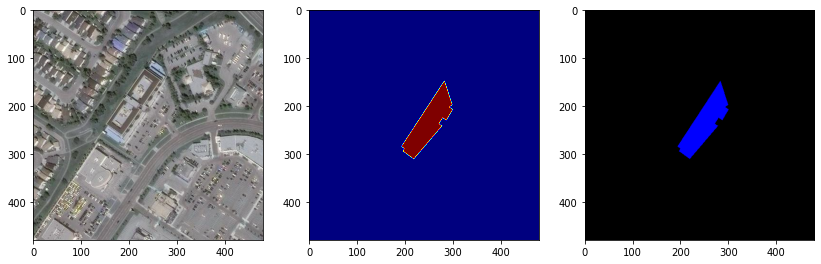

In [ ]:
#Another Sanity check, view few images
image_number = random.randint(0, len(image_dataset)-1)
#image_number = 0

plt.figure(figsize=(14, 8))
plt.subplot(131)
plt.imshow(image_dataset[image_number])
plt.subplot(132)
plt.imshow(labels[image_number][:,:,0], cmap='jet')
plt.subplot(133)
plt.imshow(mask_dataset[image_number])
plt.show()

## Training

In [7]:
n_classes = len(np.unique(labels))

from tensorflow.keras.utils import to_categorical
labels_cat = to_categorical(labels, num_classes=n_classes)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)
#_, X_test, _, y_test = train_test_split(image_dataset, labels_cat, test_size = 0.20, random_state = 42)

In [ ]:
"""
import pandas as pd
X_train_n, X_test_n, y_train_n, y_test_n = train_test_split(image_name_ls, labels_cat, test_size = 0.20, random_state = 42)

df_train = pd.DataFrame(X_train_n) 
df_train.to_csv('X_train_Baseline.csv')

df_test = pd.DataFrame(X_test_n) 
df_test.to_csv('X_test_Baseline.csv')
"""

In [8]:
#Parameters for model
# Segmentation models losses can be combined together by '+' and scaled by integer or float factor
# set class weights for dice_loss
#from sklearn.utils.class_weight import compute_class_weight
#weights = compute_class_weight('balanced', classes=np.unique(np.ravel(labels, order='C')), y=np.ravel(labels, order='C'))
#print("weights:", weights)
weights = [0.5, 0.5]
#weights = [1/3, 1/3, 1/3]

dice_loss = sm.losses.DiceLoss(class_weights=weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

### Training with standard U-Net implementation

In [ ]:
from simple_multi_unet_model import multi_unet_model, jacard_coef  
metrics=['accuracy', jacard_coef] # Define metrics shown

def get_model():
    return multi_unet_model(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)

model = get_model()
model.compile(optimizer='adam', loss=total_loss, metrics=metrics)
#model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)
#model.summary()

In [ ]:
# Fit Model
from datetime import date, datetime
date_model = date.today().strftime("%b-%d-%Y")
time_model = datetime.now().strftime("%H:%M")

history1 = model.fit(X_train, y_train,
                    batch_size=16, #len(image_dataset),
                    verbose=1,
                    epochs=30,
                    validation_data=(X_test, y_test),
                    shuffle=False)

In [ ]:
# Save model
full_date = date_model + "-" + time_model
full_date = full_date.replace(":", "")
 
model.save(f"models/unet_{full_date}.hdf5")
print(f"unet_{full_date}.hdf5"")

### Training with Segmentation-Models API

In [ ]:
from simple_multi_unet_model import multi_unet_model, jacard_coef  
metrics=['accuracy', jacard_coef, sm.metrics.IOUScore(), sm.metrics.FScore(), sm.metrics.Precision(), sm.metrics.Recall()] # Define metrics shown

#TRY ANOTHER MODEL - WITH PRETRAINED WEIGHTS
#Resnet backbone
BACKBONE = 'resnet50'  
#BACKBONE = "resnet152" # "senet154", "resnet34", 'efficientnetb4', "inceptionv3", resnet101, resnet152
preprocess_input = sm.get_preprocessing(BACKBONE)

# preprocess input
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

activation = 'sigmoid' if n_classes == 1 else 'softmax' # softmax or sigmoid for 1 class

# DEFINE MODEL
# https://segmentation-models.readthedocs.io/en/latest/api.html
# https://github.com/qubvel/segmentation_models
#model_resnet_backbone = sm.Unet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation) 
#model_resnet_backbone = sm.Linknet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation) 
#model_resnet_backbone = sm.FPN(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation) 
model_resnet_backbone = sm.PSPNet(BACKBONE, encoder_weights='imagenet', classes=n_classes, activation=activation, input_shape=(480, 480, 3)) 


# compile keras model with defined optimizer, loss and metrics
#model_resnet_backbone.compile(optimizer='adam', loss=focal_loss, metrics=metrics)
model_resnet_backbone.compile(optimizer='adam', loss='categorical_crossentropy', metrics=metrics)

#print(model_resnet_backbone.summary())

#Standard scaler
#Using categorical crossentropy as loss: 0.74

In [ ]:
# Fit Model
from datetime import date, datetime
date_model = date.today().strftime("%b-%d-%Y")
time_model = datetime.now().strftime("%H:%M")

import time 
start_time = time.localtime()
start_t = time.time()
print("Started at:", time.asctime(start_time))

# Cf. https://keras.rstudio.com/reference/fit.html
history = model_resnet_backbone.fit(X_train_prepr,
                                     y_train,
                                     batch_size=8, #########################################################
                                     #steps_per_epoch=len(X_train_prepr),
                                     #validation_steps=5, 
                                     epochs=30,
                                     verbose=1,
                                     validation_data=(X_test_prepr, y_test))

"""
sm.utils.set_trainable(model_resnet_backbone, recompile=True)
X_train_prepr = preprocess_input(X_train)
X_test_prepr = preprocess_input(X_test)

history = model_resnet_backbone.fit(X_train_prepr,
                                     y_train,
                                     batch_size=8, #########################################################
                                     #steps_per_epoch=len(X_train_prepr),
                                     #validation_steps=5, 
                                     epochs=28,
                                     verbose=1,
                                     validation_data=(X_test_prepr, y_test))
"""
end_t = time.time()
print("Computation time (Min.):", (end_t-start_t)/60)

model = model_resnet_backbone
history = history.history

Started at: Wed Jun 22 18:25:13 2022
Train on 320 samples, validate on 80 samples
Epoch 1/30
320/320 [==============================] - 23s 71ms/step - loss: 0.3194 - accuracy: 0.9247 - jacard_coef: 0.8322 - iou_score: 0.4873 - f1-score: 0.5380 - precision: 0.5511 - recall: 0.5468 - val_loss: 0.7767 - val_accuracy: 0.9518 - val_jacard_coef: 0.9083 - val_iou_score: 0.4759 - val_f1-score: 0.4876 - val_precision: 0.9759 - val_recall: 0.5000
Epoch 2/30
320/320 [==============================] - 16s 49ms/step - loss: 0.1328 - accuracy: 0.9529 - jacard_coef: 0.8726 - iou_score: 0.5586 - f1-score: 0.6381 - precision: 0.6420 - recall: 0.6437 - val_loss: 0.1943 - val_accuracy: 0.9518 - val_jacard_coef: 0.8958 - val_iou_score: 0.4842 - val_f1-score: 0.5088 - val_precision: 0.5458 - val_recall: 0.5096
Epoch 3/30
320/320 [==============================] - 16s 49ms/step - loss: 0.1130 - accuracy: 0.9560 - jacard_coef: 0.8827 - iou_score: 0.5812 - f1-score: 0.6662 - precision: 0.6704 - recall: 0.673

In [ ]:
# Save model
full_date = date_model + "-" + time_model
full_date = full_date.replace(":", "")
 
model_name = f"M513-PSPNet_sm_{full_date}"  ################

model_resnet_backbone.save(f"models/{model_name}.hdf5")

import pickle
with open(f"models/{model_name}-history.ob", 'wb') as fp:
    pickle.dump(history, fp)

print(f"{model_name}")

M513-PSPNet_sm_Jun-13-2022-1924


## Start from checkpoint

In [9]:
m_names = {"M2": "M2-unet_sm_Jun-09-2022-1711",
           "M3": "M3-linknet_sm_Jun-09-2022-1737",
           "M4": "M4-FPN_sm_Jun-09-2022-1818",
           "M5": "M5_2-PSPNet_sm_Jun-11-2022-1212"}

model_name = m_names["M5"]
#model_name = "M50-PSPNet_sm_Jun-11-2022-1244"

from keras.models import load_model
model = load_model(f"models/{model_name}.hdf5", compile=False)
                   #custom_objects={'dice_loss_plus_1focal_loss': total_loss,
                   #                'jacard_coef': jacard_coef})

import pickle
with open (f"models/{model_name}-history.ob", 'rb') as fp:
    history = pickle.load(fp)

## Get evaluation metrics

In [10]:
8# Cf. https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/metrics.py
# & https://github.com/qubvel/segmentation_models/blob/master/segmentation_models/base/functional.py
loss = history['loss'][-1]
val_loss = history['val_loss'][-1]

val_accuracy =  history['val_accuracy'][-1]
val_jacard =    history['val_jacard_coef'][-1]
val_iou_score = history['val_iou_score'][-1]
val_f1_score =  history['val_f1-score'][-1]
val_precision = history['val_precision'][-1]
val_recall =    history['val_recall'][-1]

print("Loss:          ", loss)
print("Val_Loss:      ", val_loss)
print("")
print("Val_jacard:    ", val_jacard)    # = IoU
print("")
print("Val_iou_score: ", val_iou_score)
print("Val_accuracy:  ", val_accuracy)
print("Val_f1_score:  ", val_f1_score)  # Dice coef
print("Val_precision: ", val_precision)
print("Val_recall:    ", val_recall)

Loss:           0.012634846242144704
Val_Loss:       0.1557932011783123

Val_jacard:     0.9350364804267883

Val_iou_score:  0.6846674680709839
Val_accuracy:   0.9683701395988464
Val_f1_score:   0.7740553617477417
Val_precision:  0.8812555074691772
Val_recall:     0.7212663888931274


## Plot training and validation accuracy and loss at each epoch

In [ ]:
##plot the training and validation accuracy and loss at each epoch
metrics = ["loss", "jacard_coef", "iou_score", "f1-score", "precision", "recall"]
metric = metrics[2] # IoU
#metric = metrics[3] # F1

loss = history[metric]
val_loss = history[f"val_{metric}"]

epochs = range(1, len(loss) + 1)

plt.figure(figsize=(12,8))

plt.plot(epochs, loss, 'y', label=f'Training {metric}')
plt.plot(epochs, val_loss, 'r', label=f'Validation {metric}')

plt.title(f'Training and validation {metric}')
plt.xlabel('Epochs')
plt.ylabel(metric)
plt.legend()

#plt.savefig(f'Train_History_Img/history_{metric}-PSPNET.png') ### FLAG ### CHANGE CNN Name

plt.show()

## Predictions

In [ ]:
# Evaluation
# https://github.com/qubvel/segmentation_models/blob/master/examples/multiclass%20segmentation%20(camvid).ipynb
# https://segmentation-models.readthedocs.io/en/latest/api.html
# https://www.kaggle.com/code/animeshganai/notebooka5d51c716d

In [11]:
#IOU
y_pred = model.predict(X_test)

y_pred_argmax = np.argmax(y_pred, axis=3)
y_test_argmax = np.argmax(y_test, axis=3)


#Using built in keras function for IoU
from keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test_argmax, y_pred_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.71610445


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap 

# get colormap 
ncolors = 256 
color_array = plt.get_cmap('Reds')
(range(ncolors)) 

# change alpha values 
color_array[:,-1] = np.linspace(0.0, 1.0, ncolors)

map_object = LinearSegmentedColormap.from_list(name='rainbow_alpha',colors=color_array)

# register this new colormap with matplotlib
plt.register_cmap(cmap=map_object)

/usr/local/lib/python3.7/dist-packages/matplotlib/colors.py:263: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  c = np.array(c)


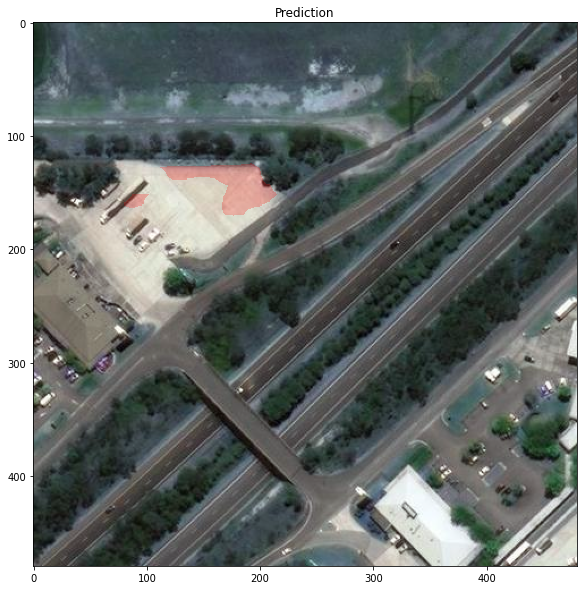

In [ ]:
#Predict on a few images
test_img_number = random.randint(0, len(X_test)-1)
#test_img_number = 16

test_img = X_test[test_img_number]
test_img_input = np.expand_dims(test_img, 0)

prediction = (model.predict(test_img_input))
predicted_img=np.argmax(prediction, axis=3)[0,:,:]

plt.figure(figsize=(10, 10))

plt.title('Prediction')
plt.imshow(test_img)

cmap_c = ListedColormap([(0.1, 0.2, 0.5, 0), "red"])

plt.imshow(predicted_img, cmap=cmap_c, alpha=0.23) # cmap="Greens",

plt.show()

In [ ]:
# Get several predicted images
id_from = 10

id_to = 20 #len(X_test)


for i in range(id_from, id_to):
    test_img = X_test[i]
    test_img_input = np.expand_dims(test_img, 0)

    prediction = (model.predict(test_img_input))
    predicted_img=np.argmax(prediction, axis=3)[0,:,:]

    plt.figure(figsize=(10, 10))

    plt.title('Prediction')
    plt.imshow(test_img)

    plt.imshow(predicted_img, cmap=cmap_c, alpha=0.2)

    plt.show()

Output hidden; open in https://colab.research.google.com to view.